In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#run if using colab
#uninstall if problem during bert tokenization then reinstall below
!pip uninstall bert-for-tf2

In [3]:
!pip install bert-for-tf2

     |████████████████████████████████| 51kB 829kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.7-cp36-none-any.whl size=30537 sha256=0df495134f51d03740375ec29fd1c9947b9c86d0069d582f09cca09c298d7a19
  Stored in directory: /root/.cache/pip/wheels/e1/f8/e2/b98f79a6b8cc898d8e4102b83acb8a098df7d27500a2bac912
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=5e6d0c7555043f66f08d4529bbc78755648e289eac491ce89559ea2a26198af2
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=1764ea705956413bc2f37f13b8db5575a7d5782f97e17a4b0d0de9d962886d5f
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [4]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 7.8MB/s 


In [5]:
!pip install emoji --upgrade

     |████████████████████████████████| 51kB 4.7MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49715 sha256=e00785c9817ca620bc5070c69848cfd82120e92608a0d85084c31fc652a95ceb
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji


In [6]:
#cd to folder which contain required external files, TEXT_MODEL.py and text_preprocessing.py
%cd /content/drive/MyDrive/Colab\ Notebooks/cs410/CourseProject 

/content/drive/MyDrive/Colab Notebooks/cs410/CourseProject


In [8]:
import tensorflow as tf 
import tensorflow_hub as hub 
from tensorflow.keras import layers
import bert
import numpy as np 
import pandas as pd 
import json
import re
import random
import math
from TEXT_PREPROCESSING import preprocess_text
from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:

# LOADING DATA
categorized_tweets = pd.read_json('./data/train.jsonl', lines = True)
categorized_tweets.isnull().values.any()
print(categorized_tweets)

# PREPROCESSING DATA
tweets = []
data = list(categorized_tweets["response"])
print(data[0])
for d in data:
    tweets.append(preprocess_text(d))

y = categorized_tweets["label"]
y = np.array(list(map(lambda x: 1 if x=="SARCASM" else 0, y)))
print(tweets[9])


            label  ...                                            context
0         SARCASM  ...  [A minor child deserves privacy and should be ...
1         SARCASM  ...  [@USER @USER Why is he a loser ? He's just a P...
2         SARCASM  ...  [Donald J . Trump is guilty as charged . The e...
3         SARCASM  ...  [Jamie Raskin tanked Doug Collins . Collins lo...
4         SARCASM  ...  [Man ... y ’ all gone “ both sides ” the apoca...
...           ...  ...                                                ...
4995  NOT_SARCASM  ...  [@USER Apologies for the inconvenience you fac...
4996  NOT_SARCASM  ...  [@USER 🤔 idk tho , I think I ’ m #hungry . But...
4997  NOT_SARCASM  ...  [@USER @USER @USER Peace to you , and two coun...
4998  NOT_SARCASM  ...  [Bernie Sanders told Elizabeth Warren in priva...
4999  NOT_SARCASM  ...  [PDP PROTEST BRAINSTORMING SESSION Deji : We n...

[5000 rows x 3 columns]
@USER @USER @USER I don't get this .. obviously you do care or you would've moved right

In [10]:
# TOKENIZING DATA
# Note: need to download file from http://nlp.stanford.edu/data/glove.twitter.27B.zip

token = tf.keras.preprocessing.text.Tokenizer()
token.fit_on_texts(tweets)
seq = token.texts_to_sequences(tweets)
maxlength = 200
vocab_size = len(token.word_index)+1

# tokenized example

#pad the input vector, tweets, so all observations have the same length
from keras.preprocessing.sequence import pad_sequences
tokenized_tweets_padded = pad_sequences(seq, maxlen=maxlength, padding = 'post')
tokenized_tweets_padded[0]

embedding_vector = {}
with open('./glove/glove.twitter.27B.200d.txt', errors ="ignore") as f:
    for line in tqdm(f):
        value = line.split(' ')
        word = value[0]
        coef = np.array(value[1:],dtype = 'float32')
        embedding_vector[word] = coef

embedding_matrix = np.zeros((vocab_size,maxlength))
for word,i in tqdm(token.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value


1193514it [01:08, 17386.76it/s]
100%|██████████| 12783/12783 [00:00<00:00, 458689.77it/s]


In [11]:
type(tokenized_tweets_padded)

numpy.ndarray

In [12]:
df_x = pd.DataFrame(tokenized_tweets_padded)
df_x.shape

(5000, 200)

In [13]:
df_x.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1,1,1,5,33,19,67,26,636,4,33,199,53,4,56,157,1534,83,786,367,4,1984,3,199,7,901,90,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,240,3,976,39,286,39,81,7,54,3825,7,31,2373,416,1140,102,11,92,1985,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,37,298,52,3826,39,8,246,42,2,2374,2920,5913,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1986,74,348,19,103,1246,54,1247,5914,7,54,5915,3827,139,37,30,2,3828,1378,31,157,249,1746,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,495,143,2,522,1535,1987,5916,11,637,30,18,2,2375,12,5917,89,31,219,1535,30,1747,462,848,407,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
#randomize and split into test and train datasets X,y
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_x, y, test_size = 0.20, shuffle = True, random_state = 33)

In [15]:
X_train.shape

(4000, 200)

In [29]:
input_length = X_train.shape[1]
VOCAB_LENGTH = len(token.word_index)+1
EMB_DIM = 200

model = tf.keras.Sequential()
model.add(layers.Embedding(VOCAB_LENGTH, EMB_DIM, weights = [embedding_matrix], input_length=input_length))
#model.add(layers.Dense(64, activation=relu ))
#model.add(layers.Dense(units=1, activation=sigmoid))

model.add(layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())

#model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(512))
model.add(layers.Dropout(rate= 0.5))
model.add(layers.Activation('relu'))

#model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(256))
model.add(layers.Dropout(rate= 0.5))
model.add(layers.Activation('relu'))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
print(model.summary())



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 200)          2556800   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 193, 32)           51232     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 96, 32)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               1573376   
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_8 (Activation)    (None, 512)              

In [30]:
# compile network
from tensorflow.keras import optimizers
opt = optimizers.Adam(learning_rate=.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer= opt, metrics=['accuracy'])
# fit network
history = model.fit(X_train, y_train, batch_size = 32, validation_data = (X_test, y_test), epochs=100, verbose=1)
# evaluate
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy: %f' % (acc*100))

Epoch 1/100
125/125 [==============================] - 3s 27ms/step - loss: 0.6941 - accuracy: 0.5192 - val_loss: 0.6750 - val_accuracy: 0.6040
Epoch 2/100
125/125 [==============================] - 3s 26ms/step - loss: 0.6871 - accuracy: 0.5455 - val_loss: 0.6685 - val_accuracy: 0.6110
Epoch 3/100
125/125 [==============================] - 3s 26ms/step - loss: 0.6837 - accuracy: 0.5520 - val_loss: 0.6646 - val_accuracy: 0.6220
Epoch 4/100
125/125 [==============================] - 3s 26ms/step - loss: 0.6787 - accuracy: 0.5820 - val_loss: 0.6615 - val_accuracy: 0.6220
Epoch 5/100
125/125 [==============================] - 3s 26ms/step - loss: 0.6746 - accuracy: 0.5847 - val_loss: 0.6592 - val_accuracy: 0.6310
Epoch 6/100
125/125 [==============================] - 3s 26ms/step - loss: 0.6707 - accuracy: 0.5932 - val_loss: 0.6568 - val_accuracy: 0.6220
Epoch 7/100
125/125 [==============================] - 3s 26ms/step - loss: 0.6727 - accuracy: 0.5860 - val_loss: 0.6548 - val_accuracy:

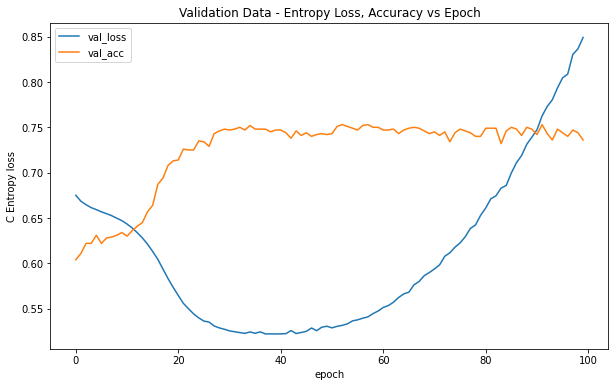

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.xlabel('epoch')
plt.ylabel('C Entropy loss')
plt.title('Validation Data - Entropy Loss, Accuracy vs Epoch')

plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(loc='upper left')

plt.savefig('./validationDataGlove.png')

In [41]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

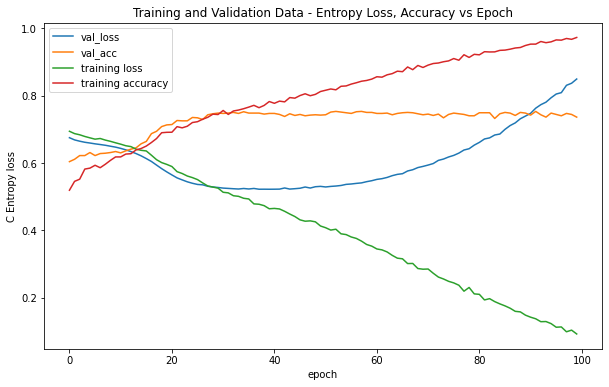

In [46]:
plt.figure(figsize=(10,6))
plt.xlabel('epoch')
plt.ylabel('C Entropy loss')
plt.title('Training and Validation Data - Entropy Loss, Accuracy vs Epoch')

plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['accuracy'], label='training accuracy')
plt.legend(loc='upper left')

plt.savefig('./val_train_dataGlove.png')

In [ ]:
#use if you want to save the model
#model.save("/content/drive/My Drive/Colab Notebooks/cs410/model1.h5")

In [ ]:
'''
# Predict using model
uncat_tweets = pd.read_json('./data/test.jsonl', lines = True)
un_tweets = []
uncat_data = list(uncat_tweets["response"])

for d in uncat_data:
    un_tweets.append(preprocess_text(d))

tokenized_un_tweets = token.texts_to_sequences(un_tweets)
'''

In [ ]:
'''
#perform check of input lengths between test and train data
count = 0
for alist in tokenized_un_tweets:
    if len(alist) > count:
        count = len(alist)
if maxlength < count:
    print('error: input of test data input len greater than train data- need to fix')
else:
    print("ok to proceed")    
'''    

error: input of test data input len greater than train data- need to fix


In [ ]:
'''
tokenized_untweets_padded = pad_sequences(tokenized_un_tweets, maxlen=maxlength, padding = 'post')
tokenized_untweets_padded[9]
'''

array([14,  5, 10,  2,  3,  1, 14,  5, 10,  2,  3,  1, 16, 16, 16,  1,  6,
        2,  1,  1, 11,  6,  7,  2,  1,  6,  2,  1,  9, 28, 12,  1,  1, 17,
        2,  3, 11,  6,  2,  7,  4,  9,  7,  1, 11,  6,  2,  1,  4,  1,  7,
        2,  1, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [ ]:

'''
predictions = model.predict(tokenized_untweets_padded)

with open('answer.txt', 'w') as f:
    c = 1
    s_c = 0
    ns_c = 0
    for p in predictions:
        if p >= .5:
            f.write("twitter_" + str(c) + "," + "SARCASM\n")
            c += 1
            s_c += 1
        else:
            f.write("twitter_" + str(c) + "," + "NOT_SARCASM\n")
            c += 1
            ns_c += 1
print("# sarcasm: " + str(s_c))
print("# not sarcasm: " + str(ns_c))

'''

# sarcasm: 1063
# not sarcasm: 737
